Assumptions: 

*ARPPU, average revenue per paying user, meaning only users who have generated revenue. Total Revenue > 0

*User age starts from 1, not 0. Today is day 1.

*Because of lack of data about LTV for User Age 8 & 9, I am dropping rows, so that I will only use the first 7 days of Users aged 8 & 9 to predict LTV

*Jelly in Media Source considered organic, Agency with no Media Source or just no Media Source will be considered organic (usually agencies charge a flat fee).

*Anybody user hasn't been converted to paid in 7 days, or users that we don't yet know if they will be converted to paid because they installed less than 7 days ago, their LTV is negligable

In [1]:
import pandas as pd
game = pd.read_csv('Game.csv', encoding = "ISO-8859-1")
game.head(5)

C:\Users\DELL1\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Install Time,Event Time,Event Name,Event Value,Event Revenue,Agency/PMD (af_prt),Media Source (pid),Campaign Name (c),Campaign ID (af_c_id),Adset Name (af_adset),...,Customer User Id,Android Id,IMEI,Advertising Id,Device Type,OS Version,SDK Version,App Version,Carrier,Sub Param 1 (af_sub1)
0,42438.34722,42438.34722,StartGame,NaN,NaN,Fyber,NaN,US_FBConnect,NaN,NaN,...,NaN,NaN,NaN,c8d8c97d-03e0-45a8-a8af-e303de2a9472,samsung-SM-N920T,22,v3.3.0,2.5.2,T-Mobile,12680
1,42438.34653,42438.34722,StartGame,NaN,NaN,NaN,supersonicads_int,FBC_US_Android_Feb2016,NaN,NaN,...,NaN,NaN,NaN,287fb7df-012b-4654-bbc7-f98271f38022,htc-HTC6435LVW,19,v3.3.0,2.5.2,Extended Network,NaN
2,42438.34653,42438.34722,StartGame,NaN,NaN,NaN,tapjoy_int,TapJoy_US_Android_FBC,NaN,NaN,...,NaN,NaN,NaN,3c198b23-e1ef-47a5-86a5-b180128c90fb,lge-LGL15G,19,v3.3.0,2.5.2,NaN,NaN
3,42438.34583,42438.34653,StartGame,NaN,NaN,NaN,supersonicads_int,FBC_US_Android_Feb2016,NaN,NaN,...,NaN,NaN,NaN,14d3c244-5cd8-4614-87cd-f70f4deeb3cd,samsung-SM-T110,17,v3.3.0,2.5.2,NaN,NaN
4,42438.34583,42438.34722,StartGame,NaN,NaN,NaN,supersonicads_int,FBC_US_Android_Feb2016,NaN,NaN,...,NaN,NaN,NaN,14d3c244-5cd8-4614-87cd-f70f4deeb3cd,samsung-SM-T110,17,v3.3.0,2.5.2,NaN,NaN


In [2]:
lis =[]
for col in game.columns:
    if len(game[pd.notnull(game[col])]) == 0:
        lis.append(col)

lis

['Ad Type (af_ad_type)', 'Region', 'State', 'Customer User Id', 'IMEI']

In [3]:
game.shape[0], game.dropna(how = 'all').shape[0]

(200000, 200000)

In [4]:
game.shape[1]

33

In [5]:
game.drop(lis, axis = 1).shape[1]

28

In [6]:
cleangame = game.drop(lis, axis = 1)

In [7]:
cleangame.columns

Index(['Install Time', 'Event Time', 'Event Name', 'Event Value',
       'Event Revenue', 'Agency/PMD (af_prt)', 'Media Source (pid)',
       'Campaign Name (c)', 'Campaign ID (af_c_id)', 'Adset Name (af_adset)',
       'Adset ID (af_adset_id)', 'Ad Name (af_ad)', 'Ad ID (af_ad_id)',
       'Site Id (af_siteid)', 'Country Code', 'City', 'IP', 'WIFI', 'Language',
       'Appsflyer Device Id', 'Android Id', 'Advertising Id', 'Device Type',
       'OS Version', 'SDK Version', 'App Version', 'Carrier',
       'Sub Param 1 (af_sub1)'],
      dtype='object')

In [8]:
pd.value_counts(cleangame['Event Revenue'])

2     283
5     202
10     49
1      36
33      9
50      6
3       4
24      2
15      1
Name: Event Revenue, dtype: int64

In [9]:
total_revenue = pd.pivot_table(cleangame, values = 'Event Revenue', index = 'Appsflyer Device Id', aggfunc = sum).dropna()
len(total_revenue)

226

Because of lack of data about LTV for User Age 8 & 9. I am dropping rows so that I will only use the first 7 days of Users aged 8 & 9 to predict LTV

In [10]:
cleangame = cleangame.drop(cleangame[(cleangame['Install Time'] < 42432) & (cleangame['Event Time'] > 42437)].index)
cleangame.shape

(194173, 28)

In [11]:
ngame = pd.pivot_table(cleangame, values = ['Install Time', 'Media Source (pid)','Agency/PMD (af_prt)'],
               index = 'Appsflyer Device Id', aggfunc = min).sort_values('Install Time', ascending = False)

ngame['Install Time'] = ngame['Install Time'].apply(lambda x: 42438 - int(x))

ngame = ngame[['Install Time', 'Agency/PMD (af_prt)','Media Source (pid)']]

In [12]:
ngame['Total Revenue'] = total_revenue
ngame = ngame.dropna(subset = ['Total Revenue'])

In [13]:
ngame.columns = ['User Age', 'Agency/PMD (af_prt)', 'Media Source (pid)',
       'Total Revenue']

In [14]:
ngame['User Age'] = ngame['User Age'].apply(lambda x: x + 1)

In [15]:
LTV_dict = { 1:0.03, 2:0.045, 3:0.0575, 4:0.07, 5:0.0815, 6:0.091, 7:0.1}

adjusting User Age as to account for previously dropped data

In [16]:
ngame['User Age'] = ngame['User Age'].replace([8,9], value = 7)

In [17]:
LTVp = []

for x, i in zip(ngame['User Age'], ngame.index):
    a = LTV_dict[x]
    LTVp.append([i,a])

In [18]:
LTV_S = pd.DataFrame(LTVp, columns = ['Appsflyer Device Id', 'ltv'])
LTV_S = LTV_S.set_index('Appsflyer Device Id')

In [19]:
ngame['LTV'] = ngame['Total Revenue'] / LTV_S['ltv']

In [20]:
ngame['Media Source (pid)'] = ngame['Media Source (pid)'].fillna('from Agency')

In [21]:
import numpy as np
avgmsource = pd.pivot_table(ngame, values = 'LTV', index = 'Media Source (pid)', aggfunc = np.mean)
fmax = avgmsource.idxmax()
print ("%s generated the highest predicted ARPPU" %(fmax))

applifier_int generated the highest predicted ARPPU


In [22]:
avgmsource

Media Source (pid)
Facebook Ads          95.873016
Jelly                 50.000000
adcolony_int         149.250298
applifier_int        240.000000
from Agency          178.477425
googleadwords_int    180.284754
jumprampgames_int    133.705467
supersonicads_int    198.452967
tapjoy_int           132.934127
vungle_int            61.229466
Name: LTV, dtype: float64

In [23]:
summsource = pd.pivot_table(ngame, values = 'LTV', index = 'Media Source (pid)', aggfunc = sum)
summsource

Media Source (pid)
Facebook Ads           575.238095
Jelly                   50.000000
adcolony_int          2089.504167
applifier_int          240.000000
from Agency           5354.322735
googleadwords_int     9194.522476
jumprampgames_int    11766.081133
supersonicads_int     1389.170768
tapjoy_int            3323.353181
vungle_int             183.688397
Name: LTV, dtype: float64

In [24]:
paidinstalls_per_msource = summsource / avgmsource
paidinstalls_per_msource

Media Source (pid)
Facebook Ads          6
Jelly                 1
adcolony_int         14
applifier_int         1
from Agency          30
googleadwords_int    51
jumprampgames_int    88
supersonicads_int     7
tapjoy_int           25
vungle_int            3
Name: LTV, dtype: float64

In [25]:
len(pd.unique(cleangame['Appsflyer Device Id']))


28396

In [26]:
cleangame['Media Source (pid)'] = cleangame['Media Source (pid)'].fillna('from Agency')
users_per_msource = pd.pivot_table(cleangame, values = 'Appsflyer Device Id', index = 'Media Source (pid)', aggfunc = lambda x: len(pd.unique(x)) )
users_per_msource

Media Source (pid)
Facebook Ads          638
Jelly                  83
adcolony_int         2781
applifier_int          65
chartboosts2s_int       5
from Agency          6904
googleadwords_int    4629
jumprampgames_int    5775
mdotm_int               1
nativex_int             2
supersonicads_int    1667
tapjoy_int           5762
vungle_int             84
Name: Appsflyer Device Id, dtype: int64

In [27]:
media = pd.DataFrame(avgmsource)
media.columns = ['ARPPU']
media['LTV'] = summsource
media['Paying Users'] = paidinstalls_per_msource
media['Installs'] = users_per_msource
media['Cost'] = 2*media['Installs']
media.loc['Jelly', 'Cost'] = 0
media.loc['from Agency', 'Cost'] = 0
media['ROI'] = media['LTV'] / media['Cost']
media

,ARPPU,LTV,Paying Users,Installs,Cost,ROI
Media Source (pid),,,,,,
Facebook Ads,95.873016,575.238095,6,638,1276,0.450814
Jelly,50.000000,50.000000,1,83,0,inf
adcolony_int,149.250298,2089.504167,14,2781,5562,0.375675
applifier_int,240.000000,240.000000,1,65,130,1.846154
from Agency,178.477425,5354.322735,30,6904,0,inf
googleadwords_int,180.284754,9194.522476,51,4629,9258,0.993143
jumprampgames_int,133.705467,11766.081133,88,5775,11550,1.018708
supersonicads_int,198.452967,1389.170768,7,1667,3334,0.416668
tapjoy_int,132.934127,3323.353181,25,5762,11524,0.288385


In this case the Media Source with the highest ARPPU also has the highest ROI, lets compare the other media sources.

In [123]:
compare = pd.DataFrame()
compare['ARPPU'] = media.sort_values('ARPPU', ascending = False).index
compare = compare.drop([5,7])
compare['ROI'] = media.sort_values('ROI', ascending = False).index[2:]
compare

,ARPPU,ROI
0,applifier_int,applifier_int
1,supersonicads_int,vungle_int
2,googleadwords_int,jumprampgames_int
3,from Agency,googleadwords_int
4,adcolony_int,Facebook Ads
6,tapjoy_int,supersonicads_int
8,vungle_int,adcolony_int
9,Jelly,tapjoy_int


They are not the same. So highest ARPPU may not necessarily indicate highest ROI, this is likely because the quality of the generated Installs are different. the potential users were perhaps aquired in different countries, or different areas of the internet which attract people of different social, economic or cultural backrounds . Applifier only generated one paying user so this too is likely a fluke. 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
events = pd.unique(game['Event Name'])
events

array(['StartGame', 'TutorialEnded', 'FBConnect', 'InviteSent',
       'FinishIsland_1', 'Sale', 'PirateBought', 'FinishIsland_22',
       'FinishIsland_2', 'FinishIsland_18', 'FinishIsland_9',
       'FinishIsland_4', 'FinishIsland_3', 'FinishIsland_5',
       'FinishIsland_11', 'FinishIsland_10', 'FinishIsland_23',
       'FinishIsland_13', 'FinishIsland_6', 'FinishIsland_20',
       'FinishIsland_16', 'FinishIsland_8', 'FinishIsland_12',
       'FinishIsland_14', 'FinishIsland_17', 'FinishIsland_7'], dtype=object)

In [9]:
import numpy as np
import re

df = pd.DataFrame(game['Event Name'])
df.columns = ['Value']
df.index.name = 'position'
df = df.reset_index()
def isFinish(x):
    return bool(re.match(r'.*Finish.*', x.ix['Value']))

def isSale(x):
    return bool(re.match(r'.*Sale.*', x.ix['Value']))

df['Finish'] = df.apply(isFinish, axis=1)
df['Sale'] = df.apply(isSale, axis=1)
df['FinishCount'] = df.Finish.cumsum()

def cumargmax(x):
    if x.ix['FinishCount'] == 0:
        return np.nan
    else:
        return df.FinishCount.loc[:x.ix['position']].argmax()

df['Distance'] = df.position - df.apply(cumargmax, axis=1)
df

,position,Value,Finish,Sale,FinishCount,Distance
0,0,StartGame,False,False,0,NaN
1,1,StartGame,False,False,0,NaN
2,2,StartGame,False,False,0,NaN
3,3,StartGame,False,False,0,NaN
4,4,StartGame,False,False,0,NaN
5,5,StartGame,False,False,0,NaN
6,6,StartGame,False,False,0,NaN
7,7,StartGame,False,False,0,NaN
8,8,StartGame,False,False,0,NaN
9,9,StartGame,False,False,0,NaN


In [10]:
sum(df['Finish'])

8664

In [11]:
df['Uniform_distribution'] = np.zeros(shape = (200000,1))
for x in np.random.permutation(df.index)[:8664]:
    df.loc[x ,'Uniform_distribution'] = 1
df

,position,Value,Finish,Sale,FinishCount,Distance,Uniform_distribution
0,0,StartGame,False,False,0,NaN,0
1,1,StartGame,False,False,0,NaN,1
2,2,StartGame,False,False,0,NaN,0
3,3,StartGame,False,False,0,NaN,0
4,4,StartGame,False,False,0,NaN,0
5,5,StartGame,False,False,0,NaN,0
6,6,StartGame,False,False,0,NaN,0
7,7,StartGame,False,False,0,NaN,0
8,8,StartGame,False,False,0,NaN,0
9,9,StartGame,False,False,0,NaN,1


In [12]:
df['RandCount'] = df['Uniform_distribution'].cumsum()
df

,position,Value,Finish,Sale,FinishCount,Distance,Uniform_distribution,RandCount
0,0,StartGame,False,False,0,NaN,0,0
1,1,StartGame,False,False,0,NaN,1,1
2,2,StartGame,False,False,0,NaN,0,1
3,3,StartGame,False,False,0,NaN,0,1
4,4,StartGame,False,False,0,NaN,0,1
5,5,StartGame,False,False,0,NaN,0,1
6,6,StartGame,False,False,0,NaN,0,1
7,7,StartGame,False,False,0,NaN,0,1
8,8,StartGame,False,False,0,NaN,0,1
9,9,StartGame,False,False,0,NaN,1,2


In [13]:
def cumargmaxrand(x):
    if x.ix['RandCount'] == 0:
        return np.nan
    else:
        return df.RandCount.loc[:x.ix['position']].argmax()

df['randDistance'] = df.position - df.apply(cumargmaxrand, axis=1)
df

,position,Value,Finish,Sale,FinishCount,Distance,Uniform_distribution,RandCount,randDistance
0,0,StartGame,False,False,0,NaN,0,0,NaN
1,1,StartGame,False,False,0,NaN,1,1,0
2,2,StartGame,False,False,0,NaN,0,1,1
3,3,StartGame,False,False,0,NaN,0,1,2
4,4,StartGame,False,False,0,NaN,0,1,3
5,5,StartGame,False,False,0,NaN,0,1,4
6,6,StartGame,False,False,0,NaN,0,1,5
7,7,StartGame,False,False,0,NaN,0,1,6
8,8,StartGame,False,False,0,NaN,0,1,7
9,9,StartGame,False,False,0,NaN,1,2,0


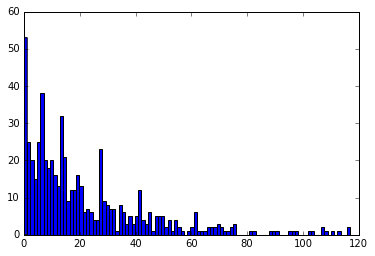

In [14]:
f_artpred = df[df['Sale']]
import matplotlib.pyplot as plt
% matplotlib inline
plt.hist(f_artpred['randDistance'], bins = 100)
plt.show()

In [15]:
def cumargmax2(x):
    if x.ix['FinishCount'] == 0:
        return np.nan
    else:
        return df2.FinishCount.loc[:x.ix['position']].argmax()


df2 = df.sort_values('position', axis = 0, ascending = False).drop(['FinishCount', 'Distance'], axis = 1)
df2 = df2.reset_index(drop = True)
df2['position'] = df2.index
df2['FinishCount'] = df2['Finish'].cumsum()
df2['Distance'] = df2['position'] - df2.apply(cumargmax2, axis = 1)
df2

,position,Value,Finish,Sale,Uniform_distribution,RandCount,randDistance,FinishCount,Distance
0,0,TutorialEnded,False,False,0,8664,50,0,NaN
1,1,StartGame,False,False,0,8664,49,0,NaN
2,2,StartGame,False,False,0,8664,48,0,NaN
3,3,StartGame,False,False,0,8664,47,0,NaN
4,4,PirateBought,False,False,0,8664,46,0,NaN
5,5,StartGame,False,False,0,8664,45,0,NaN
6,6,StartGame,False,False,0,8664,44,0,NaN
7,7,TutorialEnded,False,False,0,8664,43,0,NaN
8,8,StartGame,False,False,0,8664,42,0,NaN
9,9,StartGame,False,False,0,8664,41,0,NaN


In [16]:
f_pred = df[df['Sale']]
f_pred 

,position,Value,Finish,Sale,FinishCount,Distance,Uniform_distribution,RandCount,randDistance
380,380,Sale,False,True,2,54,0,19,35
1823,1823,Sale,False,True,31,17,0,70,14
1827,1827,Sale,False,True,32,1,0,71,3
1829,1829,Sale,False,True,32,3,0,71,5
1830,1830,Sale,False,True,32,4,0,71,6
3038,3038,Sale,False,True,53,1,0,115,31
3629,3629,Sale,False,True,66,32,0,142,20
4705,4705,Sale,False,True,84,32,0,185,43
4710,4710,Sale,False,True,85,4,0,185,48
4714,4714,Sale,False,True,85,8,0,185,52


In [17]:
f2_pred = df2[df2['Sale']]
f2_pred

,position,Value,Finish,Sale,Uniform_distribution,RandCount,randDistance,FinishCount,Distance
241,241,Sale,False,True,0,8651,3,14,28
282,282,Sale,False,True,0,8650,10,14,69
315,315,Sale,False,True,0,8648,11,16,12
324,324,Sale,False,True,0,8648,2,16,21
806,806,Sale,False,True,0,8628,14,36,13
883,883,Sale,False,True,0,8625,28,38,24
906,906,Sale,False,True,0,8625,5,38,47
953,953,Sale,False,True,0,8622,1,38,94
1669,1669,Sale,False,True,0,8586,31,70,10
1952,1952,Sale,False,True,0,8576,23,86,40


In [18]:
f2_pred = f2_pred.sort_values('position', ascending = False)
f2_pred.index = f_pred.index
f2_pred['position'] = f_pred['position']
f2_pred

,position,Value,Finish,Sale,Uniform_distribution,RandCount,randDistance,FinishCount,Distance
380,380,Sale,False,True,0,19,35,8662,13
1823,1823,Sale,False,True,0,70,14,8633,3
1827,1827,Sale,False,True,0,71,3,8632,33
1829,1829,Sale,False,True,0,71,5,8632,31
1830,1830,Sale,False,True,0,71,6,8632,30
3038,3038,Sale,False,True,0,115,31,8611,20
3629,3629,Sale,False,True,0,142,20,8598,70
4705,4705,Sale,False,True,0,185,43,8580,1
4710,4710,Sale,False,True,0,185,48,8579,14
4714,4714,Sale,False,True,0,185,52,8579,10


In [19]:
pred_bothways = pd.DataFrame()
pred_bothways['position'] = f2_pred['position']
pred_bothways['Distance_back'] = f2_pred['Distance']
pred_bothways['Distance_forward'] = f_pred['Distance']
pred_bothways = pred_bothways.set_index('position')
pred_bothways['rand_Distance'] = f_artpred['randDistance']
pred_bothways

,Distance_back,Distance_forward,rand_Distance
position,,,
380,13,54,35
1823,3,17,14
1827,33,1,3
1829,31,3,5
1830,30,4,6
3038,20,1,31
3629,70,32,20
4705,1,32,43
4710,14,4,48


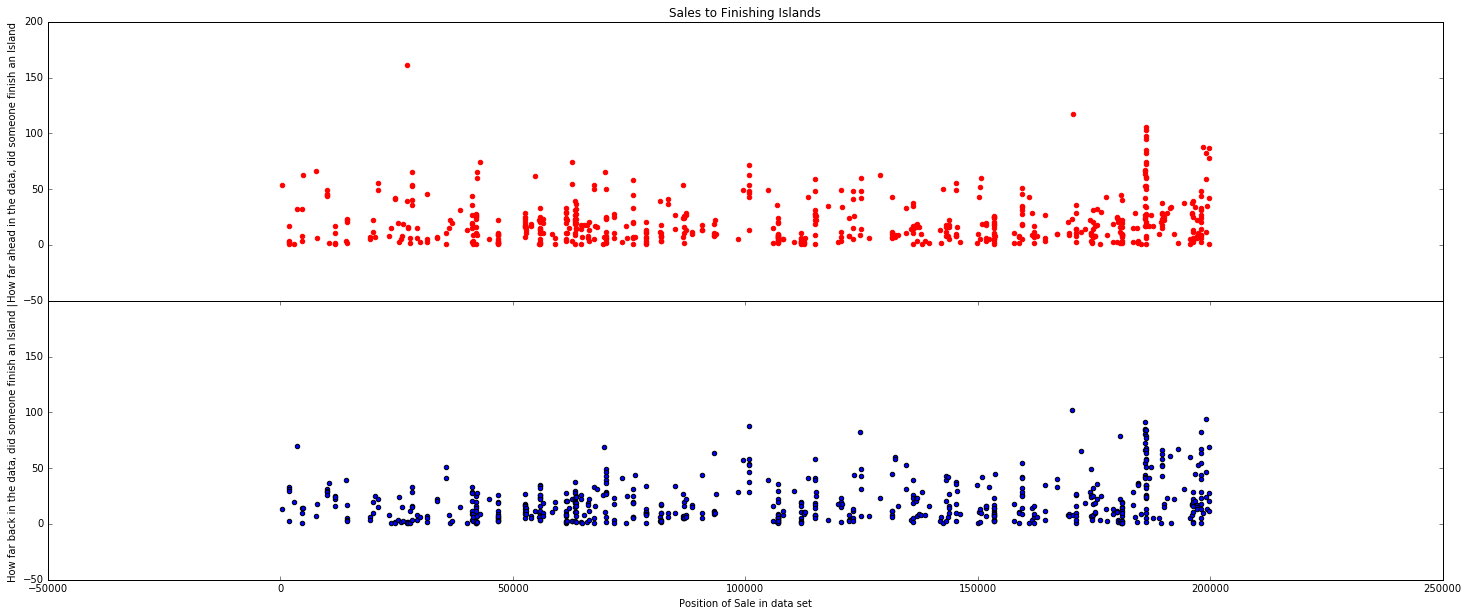

In [20]:
plt.figure(figsize = (25,10)).add_subplot(211)
plt.subplot(211).set_title('Sales to Finishing Islands')
plt.subplot(211).set_ylabel('How far ahead in the data, did someone finish an Island')
plt.subplot(211).set_xlabel('Position of Sale in data set')
plt.subplot(211).scatter(f_pred['position'], f_pred['Distance'], color = 'red')
plt.subplot(211).get_xaxis().set_visible(False)

plt.subplot(212).set_ylabel('How far back in the data, did someone finish an Island | ')
plt.subplot(212).set_xlabel('Position of Sale in data set')
plt.subplot(212).set_ylim(-50,200)
plt.subplot(212).scatter(f2_pred['position'], f2_pred['Distance'])
plt.subplot(212).set_yticks(np.arange(-50,200,50))

plt.subplots_adjust(hspace = 0)


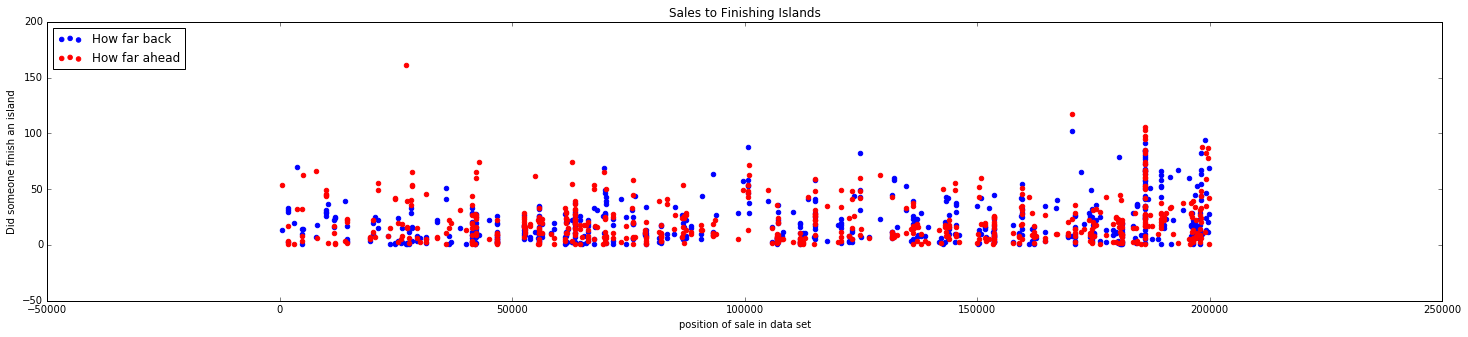

In [21]:
plt.figure(figsize = (25,5)).add_subplot(111).set(ylabel = 'Did someone finish an island', xlabel = 'position of sale in data set', title = 'Sales to Finishing Islands')
plt.subplot(111).scatter(pred_bothways.index, pred_bothways['Distance_back'], color = 'blue', label = 'How far back')
plt.subplot(111).scatter(pred_bothways.index, pred_bothways['Distance_forward'], color = 'red', label = 'How far ahead')
plt.legend(loc = 'upper left')
plt.show()

In [28]:
plt.figure(figsize = (20,10)).add_subplot(211)
plt.subplot(211).hist(pred_bothways['Distance_back'], bins = 100)
plt.subplot(211).set_title('Histogrom for finishing Islands')
plt.subplot(211).set_ylabel('How far back did someone finish an Island', rotation = 0, labelpad = 120)
plt.subplot(211).get_xaxis().set_visible(False)

plt.subplot(212).hist(pred_bothways['rand_Distance'], bins = 100)
plt.subplot(212).set_ylim(0,60)
plt.subplot(212).set_ylabel('Random Distance', rotation = 0, labelpad = 20)

plt.tight_layout()

NameError: name 'plt' is not defined

In [20]:
pred_bothways['Total_Distance'] = pred_bothways.sum(axis = 1)
pred_bothways['Min_Distance'] = pred_bothways.min(axis = 1)
pred_bothways

,Distance_back,Distance_forward,Total_Distance,Min_Distance
position,,,,
380,13,54,67,13
1823,3,17,20,3
1827,33,1,34,1
1829,31,3,34,3
1830,30,4,34,4
3038,20,1,21,1
3629,70,32,102,32
4705,1,32,33,1
4710,14,4,18,4


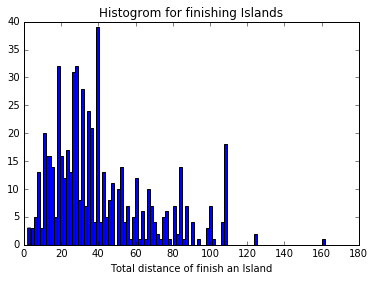

In [21]:
plt.hist(pred_bothways['Total_Distance'], bins = 100)
plt.title('Histogrom for finishing Islands')
plt.xlabel('Total distance of finish an Island')
plt.show()

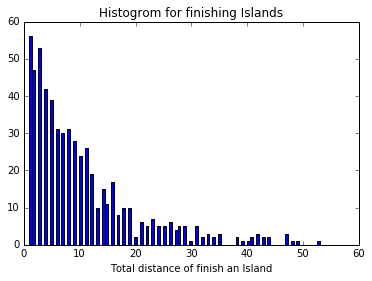

In [22]:
plt.hist(pred_bothways['Min_Distance'], bins = 100)
plt.title('Histogrom for finishing Islands')
plt.xlabel('Total distance of finish an Island')
plt.show()

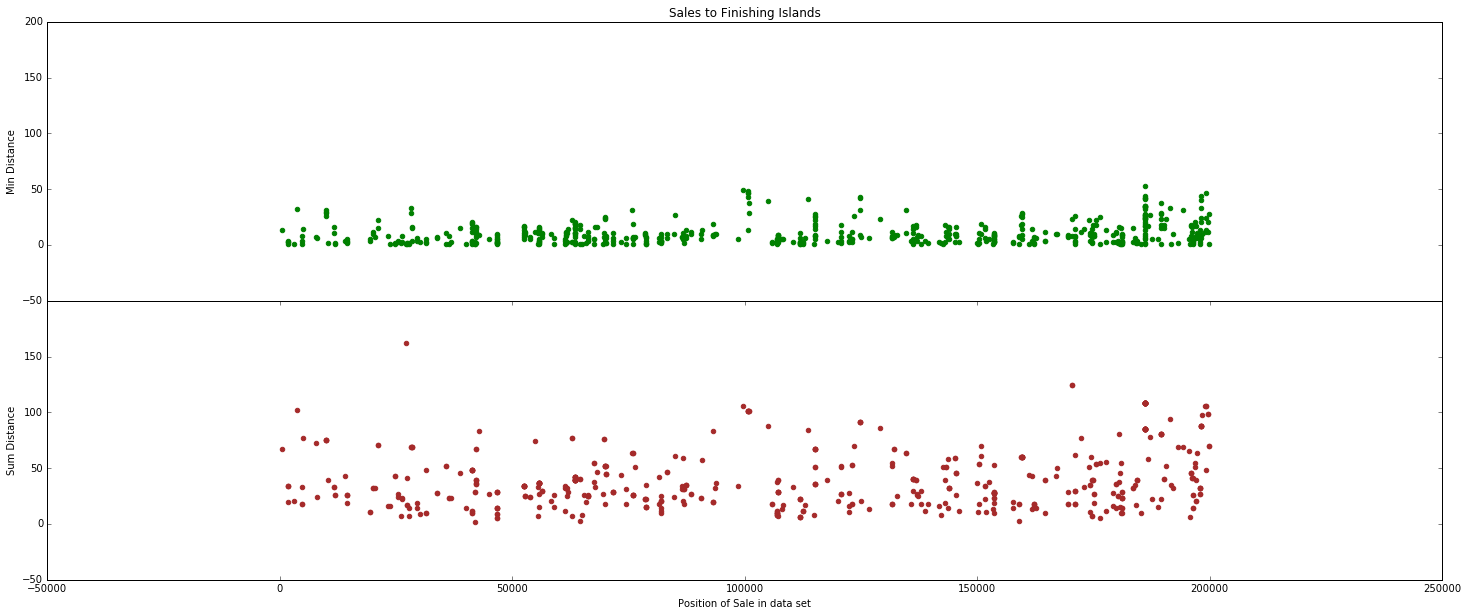

In [23]:
plt.figure(figsize = (25,10)).add_subplot(211)
plt.subplot(211).set_title('Sales to Finishing Islands')
plt.subplot(211).set_ylabel('Min Distance')
plt.subplot(211).set_xlabel('Position of Sale in data set')
plt.subplot(211).scatter(pred_bothways.index, pred_bothways['Min_Distance'], color = 'green')
plt.subplot(211).get_xaxis().set_visible(False)
plt.subplot(211).set_ylim(-50, 200)
plt.subplot(212).set_ylabel('Sum Distance')
plt.subplot(212).set_xlabel('Position of Sale in data set')

plt.subplot(212).scatter(pred_bothways.index, pred_bothways['Total_Distance'], color = 'brown')
plt.subplot(212).set_yticks(np.arange(-50,200,50))

plt.subplots_adjust(hspace = 0)

In [54]:
xgame = pd.concat([game, pred_bothways], axis = 1)

In [55]:
xgame

,Install Time,Event Time,Event Name,Event Value,Event Revenue,Agency/PMD (af_prt),Media Source (pid),Campaign Name (c),Campaign ID (af_c_id),Adset Name (af_adset),...,Advertising Id,Device Type,OS Version,SDK Version,App Version,Carrier,Sub Param 1 (af_sub1),Distance_back,Distance_forward,rand_Distance
position,,,,,,,,,,,,,,,,,,,,,
0,42438.34722,42438.34722,StartGame,NaN,NaN,Fyber,NaN,US_FBConnect,NaN,NaN,...,c8d8c97d-03e0-45a8-a8af-e303de2a9472,samsung-SM-N920T,22,v3.3.0,2.5.2,T-Mobile,12680,NaN,NaN,NaN
1,42438.34653,42438.34722,StartGame,NaN,NaN,NaN,supersonicads_int,FBC_US_Android_Feb2016,NaN,NaN,...,287fb7df-012b-4654-bbc7-f98271f38022,htc-HTC6435LVW,19,v3.3.0,2.5.2,Extended Network,NaN,NaN,NaN,NaN
2,42438.34653,42438.34722,StartGame,NaN,NaN,NaN,tapjoy_int,TapJoy_US_Android_FBC,NaN,NaN,...,3c198b23-e1ef-47a5-86a5-b180128c90fb,lge-LGL15G,19,v3.3.0,2.5.2,NaN,NaN,NaN,NaN,NaN
3,42438.34583,42438.34653,StartGame,NaN,NaN,NaN,supersonicads_int,FBC_US_Android_Feb2016,NaN,NaN,...,14d3c244-5cd8-4614-87cd-f70f4deeb3cd,samsung-SM-T110,17,v3.3.0,2.5.2,NaN,NaN,NaN,NaN,NaN
4,42438.34583,42438.34722,StartGame,NaN,NaN,NaN,supersonicads_int,FBC_US_Android_Feb2016,NaN,NaN,...,14d3c244-5cd8-4614-87cd-f70f4deeb3cd,samsung-SM-T110,17,v3.3.0,2.5.2,NaN,NaN,NaN,NaN,NaN
5,42438.34583,42438.34583,StartGame,NaN,NaN,NaN,jumprampgames_int,android_us,NaN,NaN,...,202a510d-03e1-45f1-8fe1-628910fcaad2,samsung-SM-G386T,19,v3.3.0,2.5.2,T-Mobile,NaN,NaN,NaN,NaN
6,42438.34514,42438.34722,StartGame,NaN,NaN,Fyber,NaN,US_FBConnect,NaN,NaN,...,649c3061-8872-4963-813f-e650de95cbca,lge-LG-H631,22,v3.3.0,2.5.2,NaN,34128,NaN,NaN,NaN
7,42438.34306,42438.34375,StartGame,NaN,NaN,NaN,googleadwords_int,362241398,362241398,26642833718,...,6d3bde2a-8387-4500-a588-7637a0633b54,MetroPCS-LGMS631,22,v3.3.0,2.5.2,MetroPCS,NaN,NaN,NaN,NaN
8,42438.34306,42438.34444,StartGame,NaN,NaN,Fyber,NaN,US_FBConnect,NaN,NaN,...,0e30d159-4b36-4649-8838-b4b0471f0fd4,samsung-SM-G360T1,22,v3.3.0,2.5.2,MetroPCS,31243,NaN,NaN,NaN


In [56]:
xgame.columns

Index(['Install Time', 'Event Time', 'Event Name', 'Event Value',
       'Event Revenue', 'Agency/PMD (af_prt)', 'Media Source (pid)',
       'Campaign Name (c)', 'Campaign ID (af_c_id)', 'Adset Name (af_adset)',
       'Adset ID (af_adset_id)', 'Ad Name (af_ad)', 'Ad ID (af_ad_id)',
       'Ad Type (af_ad_type)', 'Site Id (af_siteid)', 'Region', 'Country Code',
       'State', 'City', 'IP', 'WIFI', 'Language', 'Appsflyer Device Id',
       'Customer User Id', 'Android Id', 'IMEI', 'Advertising Id',
       'Device Type', 'OS Version', 'SDK Version', 'App Version', 'Carrier',
       'Sub Param 1 (af_sub1)', 'Distance_back', 'Distance_forward',
       'rand_Distance'],
      dtype='object')

In [23]:
def Create_Dummies(column):
    dummy = pd.DataFrame()
    for value in column.unique()[1:]:
        dummy[column.name + " " + str(value)] = (column == value).astype(int)
    return(dummy)

In [24]:
revenue_per_person = pd.pivot_table(cleangame, index = 'Appsflyer Device Id', values = 'Event Revenue', aggfunc = sum )
rest = pd.pivot_table(cleangame, values = ['Media Source (pid)', 'Region', 'Country Code', 'State', 'City', 'WIFI', 'Language', 'Device Type', 
                                    'OS Version', 'SDK Version', 'App Version', 'Carrier'], index = 'Appsflyer Device Id', aggfunc = min)
nmodel = pd.concat([rest, revenue_per_person], axis = 1)
nmodel

,App Version,City,Country Code,Device Type,Language,Media Source (pid),OS Version,SDK Version,WIFI,Event Revenue
Appsflyer Device Id,,,,,,,,,,
1425357163585-654996821511552825,2.5.2,Renton,US,google-Nexus 7,English,adcolony_int,18,v3.3.0,Yes,NaN
1430059298371-1264097189305637251,2.5.2,Leek,GB,samsung-SM-T315,English,tapjoy_int,19,v3.3.0,Yes,NaN
1432650013648-6657660726589971894,2.5.2,None,GB,Hudl-Hudl 2,English,tapjoy_int,22,v3.3.0,Yes,NaN
1437771045898-4679909348972568764,2.5.2,Brighton,GB,samsung-SM-T210,English,adcolony_int,19,v3.3.0,Yes,NaN
1439673615262-5292704774687873598,2.5.0,Holland,US,MetroPCS-LGMS345,English,adcolony_int,21,v3.3.0,No,NaN
1440070607509-3056905436805361946,2.5.0,None,EG,Lenovo-Lenovo A5000,English,Facebook Ads,21,v3.3.0,No,NaN
1440072397188-6387466438572520100,2.5.2,None,GB,Hudl-Hudl 2,English,adcolony_int,19,v3.3.0,Yes,NaN
1445197208044-7508271961747246501,2.5.2,None,US,samsung-GT-P5210,English,googleadwords_int,19,v3.3.0,Yes,NaN
1446069120999-4022597224089064170,2.5.2,None,GB,Hudl-Hudl 2,English,adcolony_int,19,v3.3.0,Yes,NaN


In [25]:
nmodel['Event Revenue'] = nmodel['Event Revenue'].fillna(0)

In [26]:
nmodel.columns

Index(['App Version', 'City', 'Country Code', 'Device Type', 'Language',
       'Media Source (pid)', 'OS Version', 'SDK Version', 'WIFI',
       'Event Revenue'],
      dtype='object')

In [27]:
xcol = ['App Version', 'Country Code', 'Language',
       'Media Source (pid)', 'OS Version', 'SDK Version', 'WIFI']
dummy_nmodel = pd.DataFrame()
for col in xcol:
    dummy_x = Create_Dummies(nmodel[col])
    dummy_nmodel = pd.concat([dummy_nmodel, dummy_x], axis = 1)

dummy_nmodel

,App Version 2.5.0,App Version 2.4.0,App Version 2.3.0,App Version 2.2.7,App Version 2.2.3,Country Code GB,Country Code EG,Country Code IN,Country Code UA,Country Code IQ,...,OS Version 22,OS Version 21,OS Version 17,OS Version 15,OS Version 23,OS Version 16,OS Version 10,SDK Version v2.3.1.19,SDK Version v2.3.1.17,WIFI No
Appsflyer Device Id,,,,,,,,,,,,,,,,,,,,,
1425357163585-654996821511552825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1430059298371-1264097189305637251,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1432650013648-6657660726589971894,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1437771045898-4679909348972568764,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1439673615262-5292704774687873598,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1440070607509-3056905436805361946,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1440072397188-6387466438572520100,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1445197208044-7508271961747246501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1446069120999-4022597224089064170,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
dummy_nmodel['Revenue'] = nmodel['Event Revenue']


In [43]:
dummy_nmodel['Sale'] = (dummy_nmodel['Revenue'] > 0).astype(int)

In [64]:
dummy_nmodel = dummy_nmodel.drop('Media Source (pid) nan', axis = 1)

In [65]:
import statsmodels.api as sm
resultOLS = sm.OLS(dummy_nmodel['Revenue'], sm.add_constant(dummy_nmodel.drop(['Revenue', 'Sale'], axis = 1))).fit()

In [63]:
lip =[]
for col in dummy_nmodel.columns:
    if len(dummy_nmodel.loc[dummy_nmodel[col] == 1]) == 0:
        lip.append(col)
        
print (lip)

['Media Source (pid) nan']


In [50]:
dummy_nmodel = dummy_nmodel.fillna(0)

In [70]:
for i, p in enumerate(resultOLS.pvalues):
    if p < 0.06:
        print (dummy_nmodel.columns[i - 1], resultOLS.params[i], p)


Country Code None 1.90210018846 0.0203264656873
Media Source (pid) googleadwords_int 0.102469096989 0.0521958451669
WIFI No 0.203380378137 3.15339913842e-07


In [71]:
resultOLS.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3101
Date:                Sun, 22 May 2016   Prob (F-statistic):               1.00
Time:                        10:36:08   Log-Likelihood:                -70580.
No. Observations:               28443   AIC:                         1.415e+05
Df Residuals:                   28292   BIC:                         1.427e+05
Df Model:                         150                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
const                                    0.0046      0.121      0.038      0.970        -0.232     0.241
App Version 2.5.0                       -0.1560      1.106     -0.141      0.888        -2.325     2.013
App Version 2.4.0                       -0.1222      0.746     -0.164      0.870        -1.584     1.340
App Version 2.3.0                       -0.0366      0.739     -0.049      0.961        -1.485     1.412
App Version 2.2.7                       -0.1182      2.195     -0.054      0.957        -4.421     4.185
App Version 2.2.3                       -0.0051      2.185     -0.002      0.998        -4.287     4.277
Country Code GB                         -0.0099      0.046     -0.217      0.828        -0.099     0.079
Country Code EG                         -0.0288      0.589     -0.049      0.961        -1.183     1.125
Country Code IN                         -0.0392      0.612     -0.064      0.949        -1.238     1.160
Country Code UA                          0.0897      0.398      0.225      0.822        -0.690     0.869
Country Code IQ                          0.0193      0.380      0.051      0.959        -0.725     0.764
Country Code GU                         -0.1647      1.299     -0.127      0.899        -2.710     2.380
Country Code MX                          0.0181      0.571      0.032      0.975        -1.101     1.137
Country Code LB                         -0.0444      1.313     -0.034      0.973        -2.618     2.529
Country Code GE                         -0.0570      2.052     -0.028      0.978        -4.079     3.965
Country Code DZ                          0.1125      2.076      0.054      0.957        -3.957     4.182
Country Code PR                         -0.0872      0.750     -0.116      0.907        -1.558     1.384
Country Code RO                          0.0052      0.655      0.008      0.994        -1.278     1.288
Country Code SY                         -0.0778      1.033     -0.075      0.940        -2.103     1.947
Country Code RU                          0.0916      0.332      0.276      0.782        -0.559     0.742
Country Code FR                          0.0708      1.063      0.067      0.947        -2.013     2.155
Country Code BA                         -0.0654      2.055     -0.032      0.975        -4.094     3.963
Country Code AZ                          0.0755      1.683      0.045      0.964        -3.223     3.374
Country Code VE                          0.0407      0.647      0.063      0.950        -1.227     1.308
Country Code MY                         -0.1499      0.991     -0.151      0.880        -2.093     1.793
Country Code MD                          0.0972      0.989      0.098      0.922        -1.842     2.036
Country Code BY                       